In [1]:
# ei_net.ipynb
# This notebook is used for testing a network of excitatory and inhibitory units with homeostatic inhibition
# as described in: Moldakarimov, MacClelland and Ermentrout 2006, "A homeostatic rule for inhibitory synapses 
# promotes temporal sharpening and cortical reorganization" PNAS 103(44):16526-16531.

# By Sergio Verduzco Flores        July 2017

from sirasi import *
from matplotlib import pyplot as plt
import numpy as np
import pylab
import time

In [2]:
# create some utility functions
def make_fe(th, eps): # returns a function as in Eq. 1 of the paper
    return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
def make_fi(th, eps): # returns a function as in Eq. 2 of the paper
    return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
def make_pulse(t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
    return lambda t : 1. if (t_init < t and t < t_end) else 0.
def r(i,j,sigma): # A Gaussian function with s.d. sigma, applied to i-j
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp( -0.5*( ((i-j)/sigma)**2 ) )

Execution time: 7.667194604873657 seconds
Execution time: 5.413355588912964 seconds


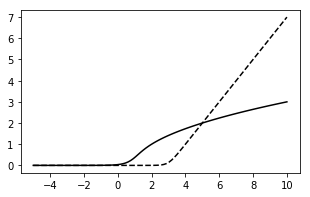

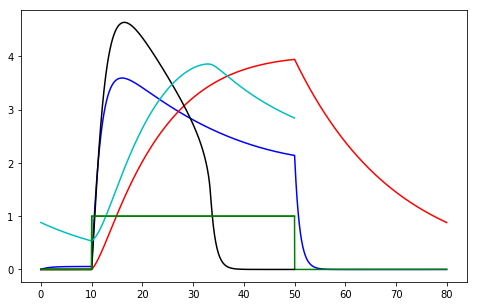

In [3]:
""" Test a single E-I pair, as in figure 2.
    It seems they may have used different durations for the transient stimulus.
    Moreover, the gain functions don't look the same, even if I match their parameters.
"""
net_params = {'min_delay' : 0.01, 'min_buff_size' : 2, 'rtol':1e-5, 'atol':1e-5 } 
net1 = network(net_params)
# creating the units
exc_params = {'tau' : 1., 'function' : make_fe(1., .2), 'type' : unit_types.custom_fi, 'init_val' : 0.0 }
inh_params = {'tau' : 20., 'function' : make_fi(3., .2), 'type' : unit_types.custom_fi, 'init_val' : 0.0 }
ext_params = {'init_val' : 0.0, 'function' : make_pulse(10., 50.), 'type' : unit_types.source, }

exc = net1.create(1, exc_params)
inh = net1.create(1, inh_params)
ext = net1.create(1, ext_params)

# connecting the units 
exc2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
exc2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
inh2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}

exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1.}
exc2exc_syn = {'type' : synapse_types.static, 'init_w' : 3.}
inh2exc_syn = {'type' : synapse_types.static, 'init_w' : -1.5}
ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 5.}
ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 5.}

net1.connect(exc, inh, exc2inh_conn, exc2inh_syn)
net1.connect(exc, exc, exc2exc_conn, exc2exc_syn)
net1.connect(inh, exc, inh2exc_conn, inh2exc_syn)
net1.connect(ext, exc, ext2exc_conn, ext2exc_syn)
net1.connect(ext, inh, ext2inh_conn, ext2inh_syn)

# running the simulation
start_time = time.time()
times, units, empty = net1.run(80.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
gain_fig = plt.figure(figsize=(5,3))
inps = np.linspace(-5.,10.,100)
exc_fr = np.array([net1.units[exc[0]].f(I) for I in inps])
inh_fr = np.array([net1.units[inh[0]].f(I) for I in inps])
pylab.plot(inps, exc_fr, 'k', inps, inh_fr, 'k--', figure=gain_fig)

act_fig = plt.figure(figsize=(8,5))
pylab.plot(times, units[exc[0]], 'b', times, units[inh[0]], 'r', times, units[ext[0]], 'g', figure=act_fig)

# A second simulation with scaled connections
for syn in net1.syns[exc[0]]:
    if syn.preID == inh[0]:
        syn.w = -3.
    elif syn.preID == exc[0]:
        syn.w = 5.
sim_time = net1.sim_time
net1.units[ext[0]].set_function(make_pulse(sim_time+10.,sim_time+50.))
start_time = time.time()
times2, units, empty = net1.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))
times = times2 - sim_time 
pylab.plot(times, units[exc[0]], 'k', times, units[inh[0]], 'c', times, units[ext[0]], 'g', figure=act_fig)
plt.show()


Execution time: 7.815298318862915 seconds
Execution time: 5.519871711730957 seconds


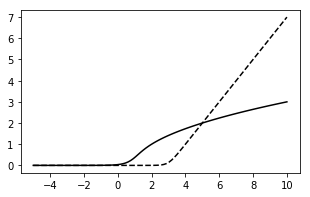

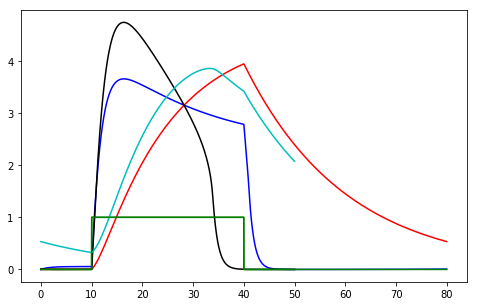

In [ ]:
""" A clone of the previous cell, with custom_sc_fi units instead of custom_fi
"""
net_params = {'min_delay' : 0.01, 'min_buff_size' : 2, 'rtol':1e-5, 'atol':1e-5 } 
net1 = network(net_params)
# creating the units
exc_params = {'tau' : 1., 'function' : make_fe(1., 0.2), 'type' : unit_types.custom_sc_fi, 'init_val' : 0.0 }
inh_params = {'tau' : 20., 'function' : make_fi(3., 0.2), 'type' : unit_types.custom_sc_fi, 'init_val' : 0.0 }
width = 30.
ext_params = {'init_val' : 0.0, 'function' : make_pulse(10., 10.+width), 'type' : unit_types.source, }

exc = net1.create(1, exc_params)
inh = net1.create(1, inh_params)
ext = net1.create(1, ext_params)

# connecting the units 
exc2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
exc2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
inh2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}

exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1., 'gain' : 1.}
exc2exc_syn = {'type' : synapse_types.static, 'init_w' : 3., 'gain' : 1.}
inh2exc_syn = {'type' : synapse_types.static, 'init_w' : -1.2, 'gain' : 1.}
ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}
ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}

net1.connect(exc, inh, exc2inh_conn, exc2inh_syn)
net1.connect(exc, exc, exc2exc_conn, exc2exc_syn)
net1.connect(inh, exc, inh2exc_conn, inh2exc_syn)
net1.connect(ext, exc, ext2exc_conn, ext2exc_syn)
net1.connect(ext, inh, ext2inh_conn, ext2inh_syn)

# running the simulation
start_time = time.time()
times, units, empty = net1.run(80.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
gain_fig = plt.figure(figsize=(5,3))
inps = np.linspace(-5.,10.,100)
exc_fr = np.array([net1.units[exc[0]].f(I) for I in inps])
inh_fr = np.array([net1.units[inh[0]].f(I) for I in inps])
pylab.plot(inps, exc_fr, 'k', inps, inh_fr, 'k--', figure=gain_fig)

act_fig = plt.figure(figsize=(8,5))
pylab.plot(times, units[exc[0]], 'b', times, units[inh[0]], 'r', times, units[ext[0]], 'g', figure=act_fig)

# A second simulation with scaled connections
for syn in net1.syns[exc[0]]:
    if syn.preID == inh[0]:
        syn.w = -3.
    elif syn.preID == exc[0]:
        syn.w = 5.
sim_time = net1.sim_time
net1.units[ext[0]].set_function(make_pulse(sim_time+10.,sim_time+10.+width))
start_time = time.time()
times2, units, empty = net1.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))
times = times2 - sim_time 
pylab.plot(times, units[exc[0]], 'k', times, units[inh[0]], 'c', times, units[ext[0]], 'g', figure=act_fig)
plt.show()

In [ ]:
""" Test a network with 20 E-I pairs, as in figure 4.
"""
md = 0.5 # minimum delay of the connections
width = 20. # width of the input pulse
net_params = {'min_delay' : md, 'min_buff_size' : 4, 'rtol':1e-4, 'atol':1e-4 } 
net2 = network(net_params)
######## creating the units
exc_params = {'tau' : 3., 'function' : make_fe(0.1, 0.2), 'type' : unit_types.custom_sc_fi, 
              'init_val' : 0.1, 'tau_fast' : 0.1 }
inh_params = {'tau' : 5., 'function' : make_fi(0.2, 0.15), 'type' : unit_types.custom_sc_fi, 
              'init_val' : 0.1, 'tau_fast' : 0.1 }
ext_params = {'init_val' : 0., 'function' : make_pulse(10., 10.+width), 'type' : unit_types.source, }

exc = net2.create(20, exc_params)
inh = net2.create(20, inh_params)
ext = net2.create(1, ext_params)

######## connecting the units
# connection specifications
exc2inh_conn = {'rule' : 'all_to_all', 'delay' : md}
exc2exc_conn = {'rule' : 'all_to_all', 'delay' : md}
inh2exc_conn = {'rule' : 'all_to_all', 'delay' : md}
ext2exc_conn = {'rule' : 'all_to_all', 'delay' : md}
ext2inh_conn = {'rule' : 'all_to_all', 'delay' : md}
# synapse specifications
# I don't have the theta and the omega parameters, I assumed theta = 1. 
# For omega I used 1 . If all weights are equal and add to c, 20w=c => w=c/20 => omega=20w^2=(c^2)/20 .
# lrate can be interpreted as the reciprocal of the synaptic time constants.
g_ee=5.; g_ie=1.; g_ei=3.5 # gains for each input type
exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1.}
exc2exc_syn = {'type' : synapse_types.sq_hebbsnorm, 'init_w' : {'distribution':'uniform', 'low':0., 'high':.5},
               'lrate' : 1./300., 'omega' : .1}  # 1/300
inh2exc_syn = {'type' : synapse_types.homeo_inh, 'init_w' : {'distribution':'uniform', 'low':-.6, 'high':0.},
               'lrate' : 1./150., #1./150., 
               'des_act' : 0.3, 'gain' : g_ei }
ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}
ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}

# neuron-to-neuron connection
sig = 3. # standard deviation of connection multiplier
base_e = exc[0] # index of first excitatory unit
base_i = inh[0]
for e,i in zip(exc,inh):  # connect with non-periodic boundary conditions
    net2.connect([i], [e], inh2exc_conn, inh2exc_syn) # inhibitory units only connect locally
    for target_e, target_i in zip(exc,inh):
        exc2exc_syn['gain'] = g_ee * r(e, target_e, 3.)
        net2.connect([e], [target_e], exc2exc_conn, exc2exc_syn)
        exc2inh_syn['gain'] = g_ie * r(e-base_e, target_i-base_i, 3.)
        net2.connect([e], [target_i], exc2inh_conn, exc2inh_syn)
        
# external input connections
net2.connect(ext, [exc[9]], ext2exc_conn, ext2exc_syn)
net2.connect(ext, [inh[9]], ext2inh_conn, ext2inh_syn)

# running the simulation
n_iters = 64
act_fig = plt.figure(figsize=(10,8))
dubyas = []  # to show the evolution of excitatory connections
for iter in range(1,n_iters+1):
    start_time = time.time()
    times, units, empty = net2.run(50.)
    if iter == 1: ole_t = times
    print('Execution time: at iteration %d is %s seconds' % (iter, (time.time() - start_time)) )
    sim_time = net2.sim_time
    net2.units[ext[0]].set_function(make_pulse(sim_time+10,sim_time+10.+width))
    if iter%8 == 0:
        pylab.plot(ole_t, units[exc[9]], 'b', ole_t, units[inh[9]], 'r', ole_t, units[ext[0]], 'g', figure=act_fig)
        dubyas.append([syn.w for syn in net2.syns[exc[9]] if syn.type == synapse_types.sq_hebbsnorm ])

'''
gain_fig = plt.figure(figsize=(5,3))
inps = np.linspace(-5.,10.,100)
exc_fr = np.array([net2.units[exc[0]].f(I) for I in inps])
inh_fr = np.array([net2.units[inh[0]].f(I) for I in inps])
pylab.plot(inps, exc_fr, 'k', inps, inh_fr, 'k--', figure=gain_fig)
'''
from mpl_toolkits.axes_grid1 import ImageGrid
dub_mat = np.matrix(dubyas)
dub_fig = plt.figure(figsize=(8,6))
dub_grid = ImageGrid(dub_fig, 111, nrows_ncols=(1,1))
dub_grid[0].imshow(dub_mat)
plt.show()

Execution time: at iteration 1 is 21.464539051055908 seconds
Execution time: at iteration 2 is 21.178858757019043 seconds
Execution time: at iteration 3 is 21.667101621627808 seconds
Execution time: at iteration 4 is 20.978956937789917 seconds
Execution time: at iteration 5 is 22.057551383972168 seconds
Execution time: at iteration 6 is 20.865371465682983 seconds
Execution time: at iteration 7 is 21.47209930419922 seconds
Execution time: at iteration 8 is 21.111464262008667 seconds
Execution time: at iteration 9 is 21.407464742660522 seconds
Execution time: at iteration 10 is 21.480139017105103 seconds
Execution time: at iteration 11 is 21.26182198524475 seconds
Execution time: at iteration 12 is 21.55153179168701 seconds
Execution time: at iteration 13 is 21.022575855255127 seconds
Execution time: at iteration 14 is 21.033209800720215 seconds
Execution time: at iteration 15 is 20.92896795272827 seconds
Execution time: at iteration 16 is 20.864121913909912 seconds


In [ ]:
# running the simulation
sim_time = net2.sim_time
net2.units[ext[0]].set_function(make_pulse(sim_time+10,sim_time+15))
start_time = time.time()
times, units, empty = net2.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
act_fig = plt.figure(figsize=(8,5))
pylab.plot(times, units[exc[9]], 'b', times, units[inh[9]], 'r', times, units[ext[0]], 'g', figure=act_fig)
plt.show()

In [ ]:
exc_w = [syn.w for syn in net2.syns[exc[0]] if syn.type is synapse_types.sq_hebbsnorm]
exc_g = [syn.gain/g_ie for syn in net2.syns[inh[9]] if syn.type is synapse_types.static]
exc_g = exc_g[0:20]
int_rang = list(range(-10,11))
gauss = [r(i,0,3) for i in int_rang]
gauss_fig = plt.figure(figsize=(6,4))
pylab.plot(int_rang, gauss)
pylab.plot(range(0,20), exc_g, 'r*')
plt.show()
sum(exc_g)

In [ ]:
[syn.w for syn in net2.syns[9]]